# IDOVEN Challenge Notebook - Jaime Cortón González

## Index

* Libraries import
* Data Loading 
* Data Visualization
* Model application
* Summary/Conclusions

## Introduction

### 12 lead ECG Context

In this database we are dealing with 12-lead ECG signals. As the name indicates this ECG is conformed of 12 different signals thet capture specific electric pulses between different strategically selected parts:

* **Lead I)** records the electrical activity between the right arm and left arm

* **Lead II)** records the electrical activity between the right arm and left leg

* **Lead III)** records the electrical activity between the left arm and left leg

* **aVR)** records the electrical activity of the heart from a perspective looking towards the right arm

* **aVL)** records the electrical activity of the heart from a perspective looking towards the left arm

* **aVF)** records the electrical activity of the heart from a perspective looking towards the left leg

* **V1)** records the electrical activity of the heart from a position on the right side of the chest

* **V2)** records the electrical activity of the heart from a position on the left side of the chest

* **V3)** records the electrical activity of the heart from a position between V2 and V4

* **V4)** records the electrical activity of the heart from a position in the mid-clavicular line of the left side of the chest

* **V5)** records the electrical activity of the heart from a position in the anterior axillary line of the left side of the chest

 * **V6)** records the electrical activity of the heart from a position in the mid-axillary line of the left side of the chest

The 12-lead ECG is used to detect various heart conditions, such as arrhythmias, ischemia, and infarction. It provides a comprehensive view of the heart's electrical activity, allowing healthcare providers to diagnose and treat heart conditions accurately.

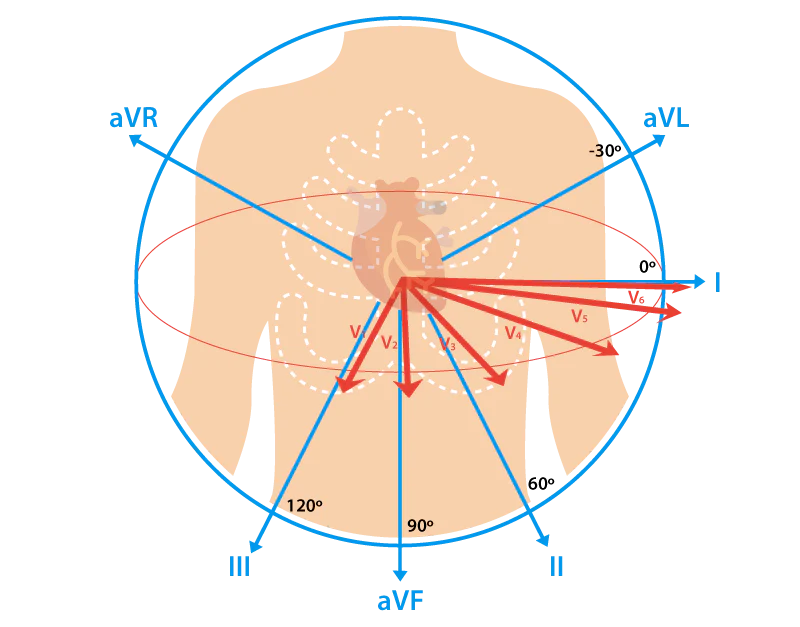
**Figure 1.** 12-Lead ECG Illustration

### Data description:

We have a dataset that consists on 2 main folders (**records100** and **records500**) containing the low resolution or high resolution files depending on the sampling frequency (100 for the ls and 500 for the hs). 

Appart from that, we also have 2 .csv files, one containing general information of each ecg like the patient_id, age, sex, nurse id (**ptbxl_database.csv**) and the other containing the list of diagnosis with its corresponding code and details (**scp_statements.csv**).

There is also a .py file with a dummmy example on how to charge the dataset (**example_physionet.py**). The rest of the files are not relevant for our study case and are mainly Licenses, formalities and metadata. A more detailed explanation of the data will be done below.

## Import libraries, ownership declaration and contact info

In [97]:
__author__="Jaime Cortón González"
__email__ ="corton35jaime@gmail.com"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast
import wfdb
from wfdb import processing
from scipy.signal import find_peaks, butter, lfilter

from utils import *

In [10]:
#!unzip -qn /home/victus-linux/Documentos/Proyectos_Git/IDOVEN_Challenge/dataset.zip

In [2]:
# Select your data loading method:

# 0 = you have already the data downloaded
# 1 = you want to download the full data directly
# 2 = you want to download the zip file


load_opt = 0   

if load_opt == 1:
    !wget -r -N -c -np https://physionet.org/files/ptb-xl/1.0.2/
    path = 'physionet.org/files/ptb-xl/1.0.2/'

elif load_opt == 2:
    !curl -o dataset.zip "https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/"
    !unzip -qn dataset.zip
    path = 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/'

else:
    # If you already have the data just modify the path line below:
    path = '/home/victus-linux/Documentos/Proyectos_Git/IDOVEN_Challenge/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/'
    print(f'Dataset already downloaded, setting path to {path}')


Dataset already downloaded, setting path to /home/victus-linux/Documentos/Proyectos_Git/IDOVEN_Challenge/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/


In [3]:
# Load General Data
sampling_rate=100

Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

X = load_raw_data(Y, sampling_rate, path)

In [4]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
val_fold  = 9

# Train
X_train = X[np.where( (Y.strat_fold != test_fold) | (Y.strat_fold != val_fold))]
y_train = Y[(Y.strat_fold != test_fold) | (Y.strat_fold != test_fold)].diagnostic_superclass
# Val
X_val = X[np.where(Y.strat_fold == val_fold)]
y_val = Y[(Y.strat_fold == val_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

## Data visualization

After loading the data lets play around a little bit and lets analyze how does our data look like. First let's see how does the complete signal looks like, on the figure below by using the built-in function of wfdb we can see perfectly the 12 different channels that give valuable information to the doctors:

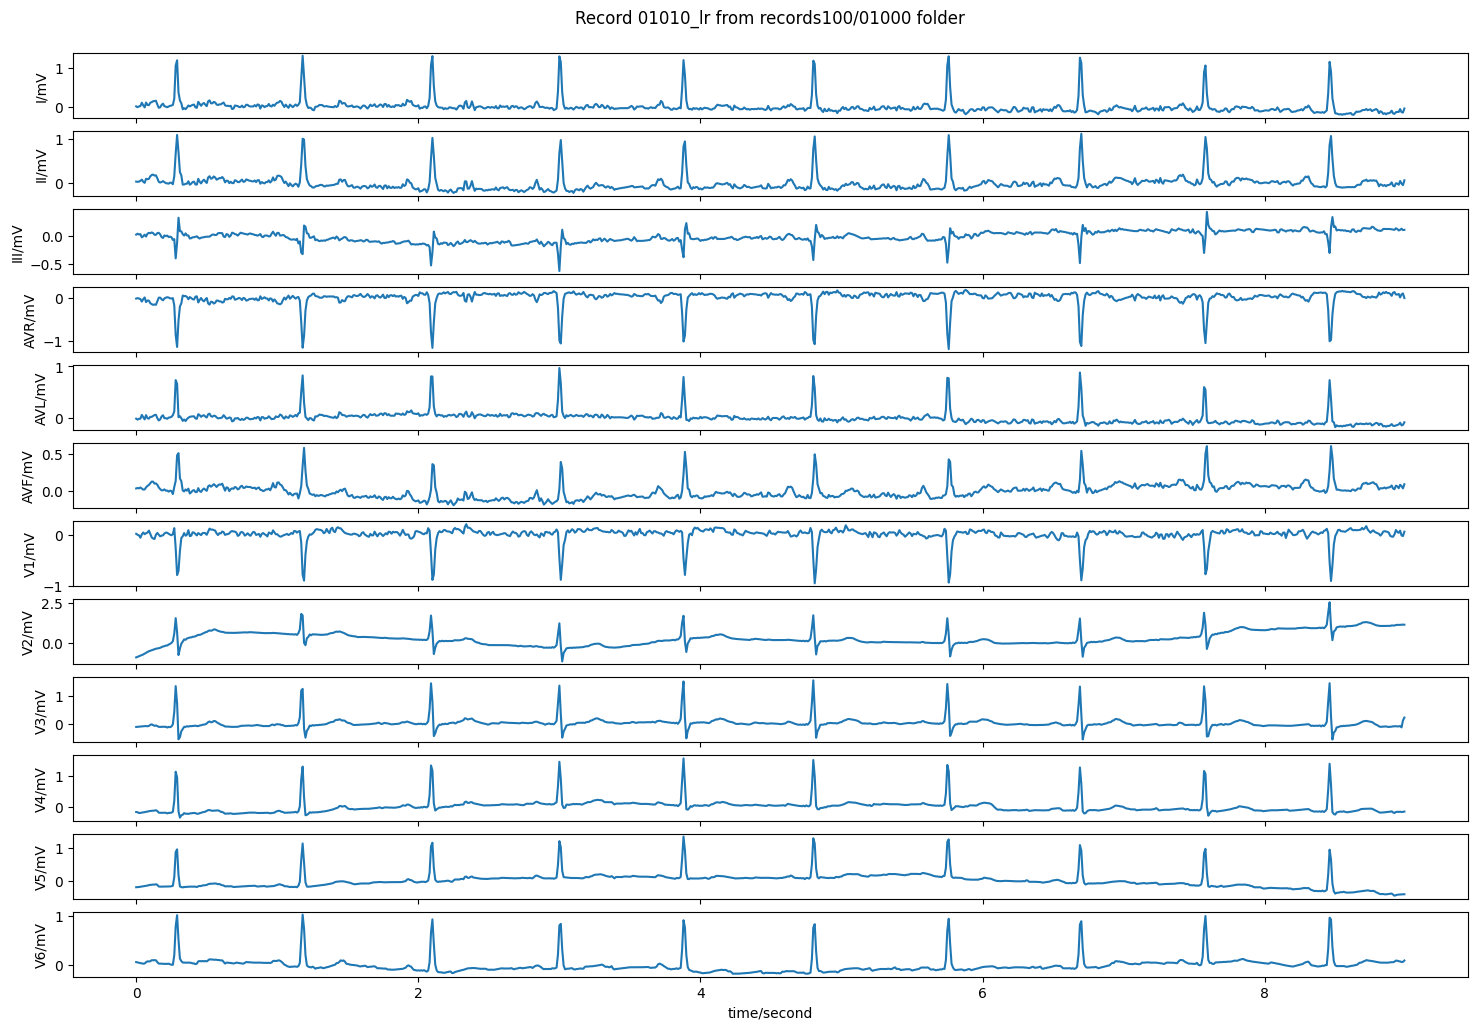

In [28]:
# Read a WFDB record. Plot all channels for certain patient

folder = 1               # This parameter will determine the first 2 digits of the folder: /records100/xx000/xx000_lr
sample = 10              # This will determine the sample taken: /records100/00000/00xxx_lr
record = wfdb.rdrecord(f'{path}/records100/{folder:02d}000/{folder:02d}{sample:03d}_lr', sampfrom = 100)

wfdb.plot_wfdb(record=record, 
               title=f'Record {folder:02d}{sample:03d}_lr from records100/{folder:02d}000 folder\n',
               time_units='seconds',
               figsize=(18, 12))

In [98]:
record = wfdb.rdrecord(f'{path}/records100/{folder:02d}000/{folder:02d}{sample:03d}_lr', sampfrom = 100, smooth_frames=1)

#Let's play with the parameters of the signal using the rdrecord function (you can see that there is a lot of info embeded)

def evaluate_record(record):

    print(f'\nSignal fs : {record.fs}')
    print(f'\nSignal n_sig : {record.n_sig}')
    print(f'\nSignal file_name : {record.file_name}')
    print(f'\nSignal comments : {record.comments}')
    print(f'\nSignal length : {record.sig_len}')
    print(f'\nSignal units : {record.units}')
    
evaluate_record(record)


Signal fs : 100

Signal n_sig : 12

Signal file_name : ['01010_lr.dat', '01010_lr.dat', '01010_lr.dat', '01010_lr.dat', '01010_lr.dat', '01010_lr.dat', '01010_lr.dat', '01010_lr.dat', '01010_lr.dat', '01010_lr.dat', '01010_lr.dat', '01010_lr.dat']

Signal comments : []

Signal length : 900

Signal units : ['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV']


Shape of training set (patients, sessions, leads) = (21801, 1000, 12)
Shape of training set (patients,) = (19603,)

Shape of validation set (patients, sessions, leads) = (2183, 1000, 12)
Shape of validation set (patients,) = (2183,)

Shape of test set (patients, sessions, leads) = (2183, 1000, 12)
Shape of test set (patients,) = (2183,)


Text(0, 0.5, 'Amplitude [mV]')

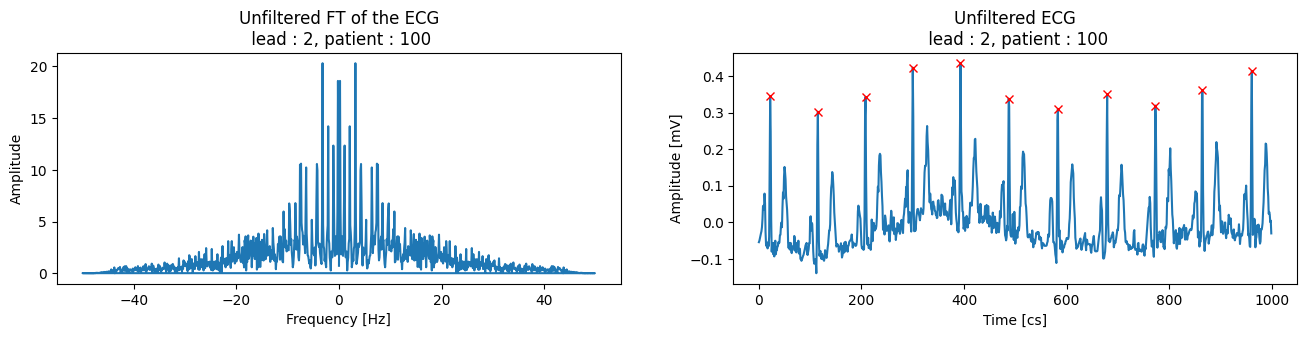

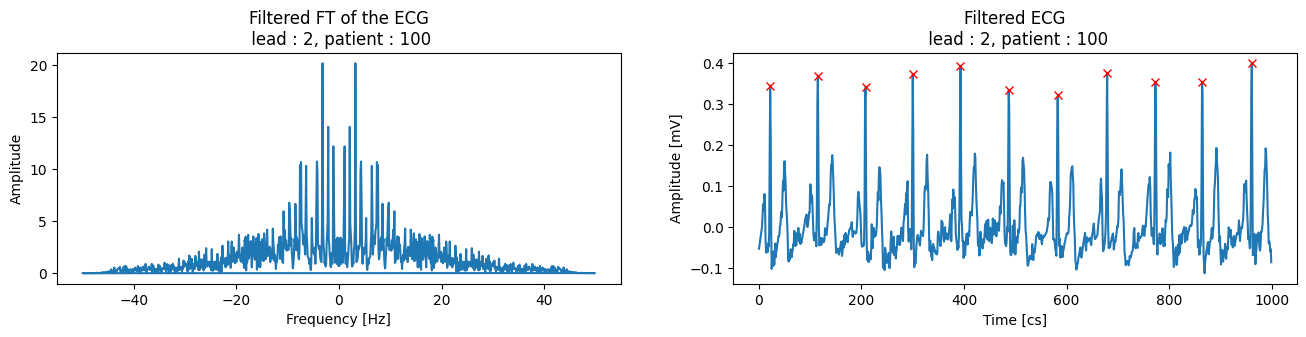

In [101]:
print(f'Shape of training set (patients, sessions, leads) = {np.shape(X_train)}')
print(f'Shape of training set (patients,) = {np.shape(y_train)}\n')
print(f'Shape of validation set (patients, sessions, leads) = {np.shape(X_val)}')
print(f'Shape of validation set (patients,) = {np.shape(y_val)}\n')
print(f'Shape of test set (patients, sessions, leads) = {np.shape(X_val)}')
print(f'Shape of test set (patients,) = {np.shape(y_val)}')

lead        = 2                                                      # Change to show a different lead (from 1 to 12)
patient     = 100                                                    # Change to show a different patient (check patient channel size to see the limit on previous print)
signal      = X_train[0,:,lead-1]                                    # Choose signal to plot
max_time    = np.shape(signal)[0]/sampling_rate 
time_steps  = np.linspace(0, max_time, np.shape(X_train[0,:,0])[0])  # Readjust x axis for temporal coordinates

peaks, _    = find_peaks(signal, prominence=0.3)                     # Dummy example on how to extract the R peaks

f = np.abs(np.fft.fft(signal))
freq_steps = np.fft.fftfreq(np.shape(signal)[0], d=1/sampling_rate)

plt.figure(figsize=(16, 3))
plt.subplot(1,2,1)
plt.plot(freq_steps, f)
plt.title(f'Unfiltered FT of the ECG\n lead : {lead}, patient : {patient}')
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.subplot(1,2,2)
plt.plot(signal)
plt.plot(peaks, signal[peaks], "xr")
plt.title(f'Unfiltered ECG\n lead : {lead}, patient : {patient}')
plt.tick_params(axis='x', which='major')
plt.xlabel('Time [cs]')
plt.ylabel('Amplitude [mV]')

# Now lets apply a simple filter to see how baseline distortion affects the visualization

filtered_sig = highpass(signal, sampling_rate, 0.30)
f            = np.abs(np.fft.fft(filtered_sig))
freq_steps   = np.fft.fftfreq(np.shape(filtered_sig)[0], d=1/sampling_rate)
peaks, _     = find_peaks(filtered_sig, prominence=0.3)                     # Dummy example on how to extract the R peaks

plt.figure(figsize=(16, 3))
plt.subplot(1,2,1)
plt.plot(freq_steps, f)
plt.title(f'Filtered FT of the ECG\n lead : {lead}, patient : {patient}')
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.subplot(1,2,2)
plt.plot(filtered_sig)
plt.plot(peaks, filtered_sig[peaks], "xr")
plt.title(f'Filtered ECG\n lead : {lead}, patient : {patient}')
plt.tick_params(axis='x', which='major')
plt.xlabel('Time [cs]')
plt.ylabel('Amplitude [mV]')


{'fs': 100, 'sig_len': 1000, 'n_sig': 3, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV', 'mV'], 'sig_name': ['I', 'II', 'III'], 'comments': []}


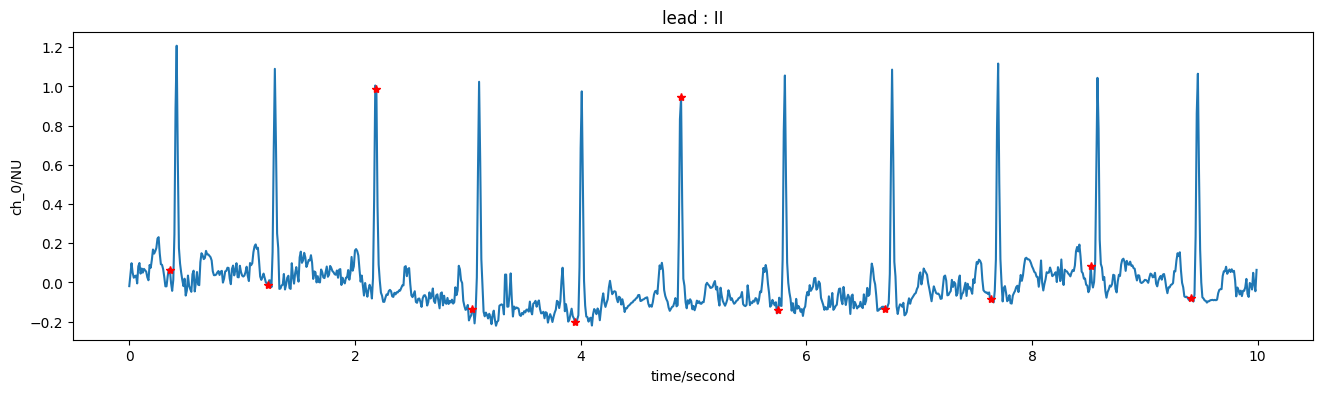

In [131]:
lead        = 1
sig, fields = wfdb.rdsamp(f'{path}/records100/{folder:02d}000/{folder:02d}{sample:03d}_lr', channels=[0,1,2])

print(fields)

xqrs_res = processing.xqrs_detect(sig=sig[:,lead],  fs=fields['fs'], verbose = False)

wfdb.plot_items(signal=sig[:,lead], fs=fields['fs'], ann_samp=[xqrs_res], figsize=(16,4), title=f'lead : {fields["sig_name"][lead]}', time_units="seconds")